In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import igraph as ig
import cairo

In [2]:
np.random.seed(31)

In [12]:
class NeuralNetwork:
    def __init__(self, n, m) -> None:
        self.n = n
        self.m = m

        self.W1 = np.random.random((m, n))
        self.b1 = np.random.random((m, 1))

        self.W2 = np.random.random((1,m))
        self.b2 = np.random.random((1,1))

    def sigmoid(self, x:'np.array'):
        return 1 / (1+np.exp(-x))

    def forward(self, x:'np.array'):
        capa1 = self.sigmoid((self.W1 @ x.reshape(-1, 1)) + self.b1)
        return (self.W2 @ capa1) + self.b2
    
    def funcion_objetivo(self, x:'np.array', y:float):
        loss = 1/2 * (self.forward(x) - y)**2
        return loss

    def numerical_gradient(self, x, y):
        ''' 
        Computa la derivada parcial de la funcion objetivo
        con respecto a cada uno de los parametros. 
        ------------
        Devuelve las derivadas en el orden (W1, b1, W2, b2)
        '''
        eps = 1e-3

        # Derivada con respecto a W1
        W1_derv = np.zeros(self.W1.shape)
        for i in range(self.m):
            for j in range(self.n):
                self.W1[i][j] += eps
                loss_mas = self.funcion_objetivo(x, y)
                self.W1[i][j] -= 2*eps
                loss_menos = self.funcion_objetivo(x, y)

                self.W1[i][j] += eps

                W1_derv[i][j] =  (loss_mas - loss_menos) / (2*eps)

        # Derivada con respecto a b1
        b1_derv = np.zeros(self.b1.shape)
        for j in range(self.m):
            self.b1[j] += eps
            loss_mas = self.funcion_objetivo(x, y)
            self.b1[j] -= 2*eps
            loss_menos = self.funcion_objetivo(x, y)

            self.b1[j] += eps

            b1_derv[j] =  (loss_mas - loss_menos) / (2*eps)

        # Derivada con respecto a W2
        W2_derv = np.zeros(self.W2.shape)
        for j in range(self.m):
            self.W2[0][j] += eps
            loss_mas = self.funcion_objetivo(x, y)
            self.W2[0][j] -= 2*eps
            loss_menos = self.funcion_objetivo(x, y)

            self.W2[0][j] += eps

            W2_derv[0][j] =  (loss_mas - loss_menos) / (2*eps)

        # Derivada con respecto a b2
        b2_derv = 0
        self.b2 += eps
        loss_mas = self.funcion_objetivo(x,y)
        self.b2 -= 2*eps
        loss_menos = self.funcion_objetivo(x,y)
        self.b2 += eps
        b2_derv = (loss_mas - loss_menos) / (2*eps)

        gradiente = (W1_derv, b1_derv, W2_derv, b2_derv)
        return gradiente
    
    def fit(self, x, y, learning_rate=0.001, epochs=1000):
        loss_accum = []
        for j in range(epochs):
            meanW1 = np.zeros(self.W1.shape)
            meanb1 = np.zeros(self.b1.shape)
            meanW2 = np.zeros(self.W2.shape)
            meanb2 = 0
            meanLoss = 0
            
            for i in range(len(x)): 
                W1, b1, W2, b2 = self.numerical_gradient(x[i], y[i]) 
                meanW1 += W1/len(x)
                meanb1 += b1/len(x)
                meanW2 += W2/len(x)
                meanb2 += b2/len(x)
                meanLoss += self.funcion_objetivo(x[i], y[i])/len(x)

            self.W1 -= learning_rate * meanW1
            self.b1 -= learning_rate * meanb1
            self.W2 -= learning_rate * meanW2
            self.b2 -= learning_rate * meanb2

            loss_accum.append(meanLoss)

            print(meanLoss, learning_rate, j)

        return loss_accum
        
    def predict(self, x):
        y = self.forward(x)
        return y
    

    def plot(self, w, h):
        def nn_layout(g):
            layout = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0.5), (1, 1.5), (1, 2.5), (1, 3.5), (1, 4.5), (2, 2.5)]
            return layout


        # Create a graph object
        g = ig.Graph()
        g.add_vertices(self.n+self.m+1)

        W1_std = (self.W1 - self.W1.mean())/(self.W1.std())
        for i in range(self.m):
            for j in range(self.n):
                g.add_edge(i, j + self.m, weight=W1_std[i, j])  # Add edge with weight

        W2_std = (self.W2 - self.W2.mean())/(self.W2.std())
        for j in range(self.n):
            g.add_edge(j + self.m, self.m+self.n, weight=W2_std[0][j]) 

        # Get the custom layout
        layout = nn_layout(g)

        # Visualize the graph with the custom layout
        visual_style = {}
        visual_style["vertex_size"] = 20
        visual_style["vertex_color"] = "lightblue"
        visual_style["edge_color"] = ['green' if x > 0 else 'red' for x in g.es['weight']]
        visual_style["edge_width"] = [abs(x) for x in g.es['weight']]

        return ig.plot(g, layout=layout, bbox=(w, h), **visual_style)

        

In [4]:
df = pd.read_excel('./Real estate valuation data set.xlsx')
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
x_train = df.iloc[:315, 1:7]
y_train = df.iloc[:315, 7]
x_test = df.iloc[315:, 1:7]
y_test = df.iloc[315:, 7]

x_train_min = x_train[:10]
y_train_min = y_train[:10]

In [6]:
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
normalized_data = (x_train - mean) / std

In [51]:
nn = NeuralNetwork(6, 5)
loss = nn.fit(normalized_data.to_numpy(), y_train.to_numpy(), learning_rate=0.001)

[[749.27486244]]
[[745.3539869]]
[[741.44421902]]
[[737.5451081]]
[[733.6562192]]
[[729.77713303]]
[[725.9074458]]
[[722.04676921]]
[[718.19473027]]
[[714.35097129]]
[[710.51514974]]
[[706.68693822]]
[[702.86602431]]
[[699.05211057]]
[[695.24491437]]
[[691.4441679]]
[[687.64961804]]
[[683.8610263]]
[[680.07816873]]
[[676.30083583]]
[[672.52883251]]
[[668.76197795]]
[[665.00010555]]
[[661.24306282]]
[[657.49071131]]
[[653.74292645]]
[[649.99959753]]
[[646.26062752]]
[[642.52593298]]
[[638.79544393]]
[[635.06910375]]
[[631.346869]]
[[627.62870931]]
[[623.91460719]]
[[620.20455791]]
[[616.4985693]]
[[612.7966616]]
[[609.09886725]]
[[605.40523067]]
[[601.71580812]]
[[598.03066742]]
[[594.34988775]]
[[590.67355939]]
[[587.00178354]]
[[583.33467195]]
[[579.67234677]]
[[576.01494019]]
[[572.36259419]]
[[568.71546023]]
[[565.07369895]]
[[561.43747988]]
[[557.80698107]]
[[554.18238878]]
[[550.56389716]]
[[546.95170788]]
[[543.34602978]]
[[539.74707851]]
[[536.1550762]]
[[532.57025102]]
[[528.99

In [13]:
nn2 = NeuralNetwork(6, 5)
loss = nn2.fit(normalized_data.to_numpy(), y_train.to_numpy(), epochs=1500)

[[746.85005639]] 0.001 0
[[742.96793348]] 0.001 1
[[739.09634112]] 0.001 2
[[735.23481143]] 0.001 3
[[731.38289461]] 0.001 4
[[727.54015889]] 0.001 5
[[723.70619049]] 0.001 6
[[719.88059352]] 0.001 7
[[716.06298994]] 0.001 8
[[712.25301952]] 0.001 9
[[708.45033977]] 0.001 10
[[704.65462585]] 0.001 11
[[700.86557054]] 0.001 12
[[697.08288415]] 0.001 13
[[693.30629444]] 0.001 14
[[689.53554655]] 0.001 15
[[685.77040288]] 0.001 16
[[682.01064304]] 0.001 17
[[678.25606366]] 0.001 18
[[674.50647837]] 0.001 19
[[670.76171757]] 0.001 20
[[667.02162837]] 0.001 21
[[663.28607437]] 0.001 22
[[659.55493552]] 0.001 23
[[655.82810794]] 0.001 24
[[652.10550372]] 0.001 25
[[648.38705068]] 0.001 26
[[644.67269219]] 0.001 27
[[640.96238688]] 0.001 28
[[637.25610841]] 0.001 29
[[633.55384519]] 0.001 30
[[629.85560007]] 0.001 31
[[626.16139006]] 0.001 32
[[622.47124601]] 0.001 33
[[618.78521224]] 0.001 34
[[615.10334622]] 0.001 35
[[611.42571819]] 0.001 36
[[607.75241078]] 0.001 37
[[604.08351865]] 0.001

KeyboardInterrupt: 

In [52]:
mean_test = np.mean(x_test, axis=0)
std_test = np.std(x_test, axis=0)
normalized_data = (x_test - mean_test) / std_test

for i in range(len(x_test)):
    x = normalized_data.iloc[i].to_numpy()
    y = y_test.iloc[i]
    print(round(nn.predict(x)[0][0], 1), y)

39.9 27.3
43.6 42.0
40.8 37.5
44.5 49.8
35.8 26.9
14.3 18.6
43.5 37.7
39.4 33.1
43.8 42.5
28.1 31.3
43.2 38.1
43.1 62.1
43.7 36.7
34.5 23.6
15.6 19.2
20.0 12.8
16.3 15.6
38.2 39.6
42.4 38.4
43.4 22.8
42.5 36.5
40.5 35.6
41.0 30.9
43.4 36.3
44.3 50.4
35.2 42.9
42.0 37.0
44.2 53.5
43.7 46.6
38.5 41.2
37.8 37.9
32.0 30.8
19.0 11.2
43.9 53.7
42.4 47.0
41.6 42.3
30.7 28.6
25.2 25.7
33.5 31.3
30.3 30.1
44.2 60.7
39.3 45.3
44.4 44.9
43.6 45.1
31.2 24.7
43.9 47.1
43.1 63.3
43.9 40.0
44.4 48.0
43.7 33.1
29.3 29.5
26.6 24.8
28.3 20.9
40.5 43.1
25.9 22.8
43.6 42.1
41.1 51.7
42.1 41.5
41.5 52.2
44.1 49.5
31.9 23.8
31.9 30.5
43.5 56.8
43.5 37.4
44.3 69.7
44.1 53.3
44.5 47.3
15.6 29.3
41.5 40.3
14.5 12.9
44.3 46.6
38.5 55.3
29.6 25.6
32.5 27.3
42.9 67.7
44.0 38.6
31.4 31.3
42.7 35.3
43.6 40.3
19.1 24.7
42.0 42.5
34.9 31.9
44.1 32.2
31.9 23.0
39.1 37.3
42.9 35.5
31.2 27.7
38.8 28.5
43.8 39.7
44.1 41.2
37.9 37.2
44.1 40.5
29.5 22.3
30.9 28.1
16.1 15.4
44.2 50.0
44.1 40.6
42.8 52.5
44.4 63.9


In [53]:
loss[-1]

array([[46.71795314]])

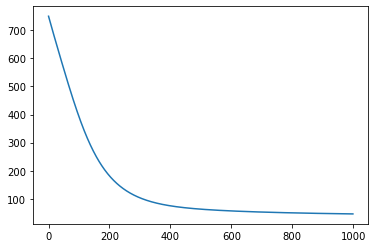

In [54]:
loss = [l.flatten()[0] for l in loss]
plt.plot(loss)

In [ ]:
def ECM(nn, x_test, y_test):
    EC_acumulado = 0 
    for i in range(len(x_test)):
        x_predict = nn.predict(x_test.to_numpy()[i])
        EC_acumulado += (x_predict - y_test.to_numpy()[i])**2

    return EC_acumulado/len(x_test)
        